In [1]:
from __future__ import annotations

#os packages
import os
import itertools
import glob

#Data Packages
import numpy as np
import dask.array as da
import xarray as xr

#xarray parellel
from distributed import Client
Client()

#Plotting Packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import AnchoredText
from matplotlib import gridspec, colors, cm, ticker

import lcc_plotting_functs as lcc_pf     #.py file containing plotting functions for LCC gridline ticks

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cartopy.io.img_tiles as cimgt

from datetime import datetime, timedelta

#MPL inline magic
%matplotlib inline

2023-08-24 14:44:02,534 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-0v8pax4k', purging
2023-08-24 14:44:02,534 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-5onr_tqn', purging
2023-08-24 14:44:02,535 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-wu9rq_1c', purging


In [2]:
#set up a dask env. 
from distributed import Client

# Depending on your workstation specifications, you may need to adjust these values.
# On a single machine, n_workers=1 is usually better.
client = Client(n_workers=4, threads_per_worker=4, memory_limit="64GB") #mem limit * n_workers = total memory allocated
client

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38272 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:38272/status,
Dashboard: http://127.0.0.1:38272/status,Workers: 4
Total threads: 16,Total memory: 238.42 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40512,Workers: 4
Dashboard: http://127.0.0.1:38272/status,Total threads: 16
Started: Just now,Total memory: 238.42 GiB
Comm: tcp://127.0.0.1:33643,Total threads: 4
Dashboard: http://127.0.0.1:44846/status,Memory: 59.60 GiB
Nanny: tcp://127.0.0.1:33106,


#### Grab necessary files

In [3]:
#grab grid information
path_grid = r"/home/scratch/ahaberlie/simgeog"
grid = xr.open_dataset(os.path.join(path_grid,"geo_em.d01.nc"))
print(grid.CLONG[0])

<xarray.DataArray 'CLONG' (south_north: 899, west_east: 1399)>
[1257701 values with dtype=float32]
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    units:        degrees longitude
    description:  Computational longitude on mass grid
    stagger:      M
    sr_x:         1
    sr_y:         1


In [4]:
import glob
from datetime import datetime, timedelta

def filter_valid_file_paths(file_paths):
    valid_file_paths = []
    for path in file_paths:
        if os.path.exists(path):
            valid_file_paths.append(path)
    return valid_file_paths

def get_files_in_date_range(path, date_range, hours_offset):
    date_format = "%Y-%m-%d"  # Format of the date range string

    # Parse the date range string to obtain start and end dates
    start_date_str, end_date_str = date_range.split(" to ")
    start_date = datetime.strptime(start_date_str, date_format)
    end_date = datetime.strptime(end_date_str, date_format)
    
    # Apply the offset to the start and end dates
    hours_offset+= 24 # we need to account for the offset coming at the end of the day, not just off of the start time, thus we "move ahead" 24 hours
    offset_timedelta = timedelta(hours=hours_offset)
    #start_date += offset_timedelta  #####do not shift the start date
    end_date += offset_timedelta

    # Initialize the list of files
    files = []

    # Iterate over each date in the date range
    current_date = start_date
    while current_date <= end_date:
        folder_year = current_date.year
        year = current_date.year
        month = current_date.month
        day = current_date.day

        # Adjust year if the date is after September 30th
        if month < 9 or (month == 9 and day <= 30):
            folder_year -= 1

        # Get the path to the files for the current date
        fpath = f"{path}/{folder_year}-{folder_year+1}/AFWA_TOTPRECIP_{year}-{month:02d}-{day:02d}.nc"
        #print(fpath)

        # Retrieve the files using glob
        files.extend([fpath])#glob.glob(fpath))

        # Increment the current date by 1 day
        current_date += timedelta(days=1)

    return filter_valid_file_paths(files)


In [5]:
hours_offset = 12 #format integer representing hours (+/- from 0000UTC)
yr_ = 2099
date_start = f'{yr_}-10-01' # format: 'yyyy-mm-dd'
date_end = f'{yr_+1}-09-30'
year_range = f'{date_start[:4]}-{date_end[:4]}'
print(year_range)

#potential_files_to_open = get_files_in_date_range("/home/scratch/ahaberlie/AFWA_TOTPRECIP/HIST", f'{date_start} to {date_end}', hours_offset)
potential_files_to_open = get_files_in_date_range("/home/scratch/ahaberlie/AFWA_TOTPRECIP/end_of_century_8p5", f'{date_start} to {date_end}', hours_offset)
files_to_open = []

for path in potential_files_to_open:
    # Extract the date from the file path
    date_string = path.split("/")[-1].split("_")[2].split(".")[0]
    #print(date_string)
    # Check if the date corresponds to February 29th
    if date_string.endswith("02-29"):
        continue  # Skip this file path
    else:
        files_to_open.append(path)
print(len(files_to_open))
#[print(f) for f in files_to_open]

2099-2100
365


In [6]:
da = xr.open_mfdataset(files_to_open,
                            chunks='auto',
                            combine='by_coords',
                            engine='netcdf4')

da = da.assign_coords(lon=grid.CLONG[0], lat=grid.CLAT[0])

t = da.AFWA_TOTPRECIP[0].Time.values
t_label = np.datetime_as_string(t, unit='m')

#max, min = ds.AFWA_TOTPRECIP[0].max(), ds.AFWA_TOTPRECIP[0].min().compute()

#print(f"Min: {min}/tMax:{max}")


#### Resampling

In [7]:
#subset to all hours that are not part of the offset
# we can't use the following notation because ...T>24:00>00 throws an error, need to apply a datetime timedelta. The da.sel method supports datetime objects
#da_shifted = da.sel(Time=slice(f'{date_start}T{hours_offset}:00:00', f'{date_end}T{hours_offset}:00:00'))#.groupby('time.month').mean('time')
t_srt = datetime.strptime(date_start, '%Y-%m-%d') + timedelta(hours=hours_offset)
t_end = datetime.strptime(date_end, '%Y-%m-%d') + timedelta(hours=23 + hours_offset, minutes = 59) # we add 24 here because we want all of the final day, not just the start time
print(f'start time of range: {t_srt}')
print(f'end time of range: {t_end}')

thresh_val = .254   #units: mm (base of 0.01" from:  https://www.researchgate.net/publication/334741215_Trends_in_Precipitation_Days_in_the_United_States, (Vestal 1961; Harrison 1983) )
da_sum_daily = da.sel(Time=slice(t_srt, t_end)).resample(Time='1D', offset = timedelta(hours=hours_offset)).sum('Time')

#reeanable toe following line fir boolean output and ajust the file save dataset
#da_bool_daily = da_sum_daily >= thresh_val
#thresholded_array = data <= threshold


start time of range: 2099-10-01 12:00:00
end time of range: 2100-10-01 11:59:00


In [8]:
#da_bool_daily

"\nmesh = da_bool_daily.AFWA_TOTPRECIP[0].plot.pcolormesh(x='lon', y='lat',\n                                             add_colorbar=False,\n                                             cmap = colors.ListedColormap(['lightgray', 'black'])\n                                             #levels=2\n                                             #xlim=[min_lon - .5, max_lon + .5],\n                                             #ylim=[min_lat - .5, max_lat + .5],\n                                             #norm=colors.LogNorm(vmin=0.000001, clip=True),\n                                            )\n                                            "

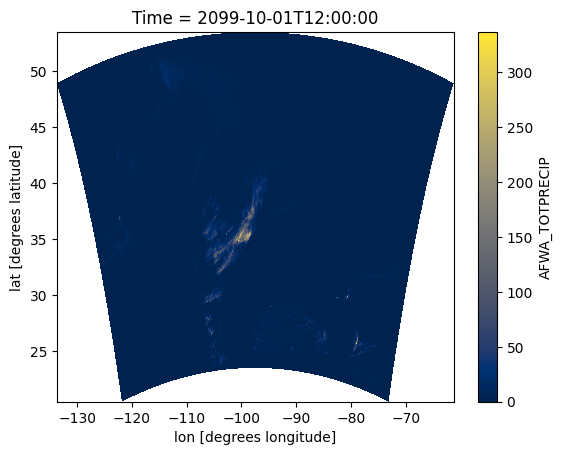

In [9]:
mesh = da_sum_daily.AFWA_TOTPRECIP[0].plot.pcolormesh(x='lon', y='lat',
                                             #add_colorbar=False,
                                             cmap = 'cividis'#= colors.ListedColormap(['lightgray', 'black'])
                                             #levels=2
                                             #xlim=[min_lon - .5, max_lon + .5],
                                             #ylim=[min_lat - .5, max_lat + .5],
                                             #norm=colors.LogNorm(vmin=0.000001, clip=True),
                                            )
'''
mesh = da_bool_daily.AFWA_TOTPRECIP[0].plot.pcolormesh(x='lon', y='lat',
                                             add_colorbar=False,
                                             cmap = colors.ListedColormap(['lightgray', 'black'])
                                             #levels=2
                                             #xlim=[min_lon - .5, max_lon + .5],
                                             #ylim=[min_lat - .5, max_lat + .5],
                                             #norm=colors.LogNorm(vmin=0.000001, clip=True),
                                            )
                                            '''

In [10]:
# save out, write mode only to avoid overwrites, 
# todo: Automate path_out, Still need to fix some data array labels and metadata


path_out=f"/home/sleake/AFWA_TOTPRECIP_Daily_eoc8p5/AFWA_TOTPRECIP_Daily_eoc8p5_{year_range}_12z.nc"
out = da_sum_daily.to_netcdf(path=path_out,
                         mode="w")

'''
path_out=f"/home/sleake/AFWA_TOTPRECIP_PrecipDays_hist/AFWA_TOTPRECIP_PrecipDays_{year_range}_12z_0p254.nc"
out = da_bool_daily.to_netcdf(path=path_out,
                         mode="w")
'''

'\npath_out=f"/home/sleake/AFWA_TOTPRECIP_PrecipDays_hist/AFWA_TOTPRECIP_PrecipDays_{year_range}_12z_0p254.nc"\nout = da_bool_daily.to_netcdf(path=path_out,\n                         mode="w")\n'